### Import libraries

In [1]:
import sys
sys.path.append("../")

In [2]:
import os
from os import environ
import numpy as np
from random import choices
import pandas as pd
from tqdm.notebook import tqdm

In [3]:
import skimage.io as io

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.transforms as mtrans
%matplotlib inline

In [5]:
from preprocess.common import load_nii

In [6]:
from torch.utils.data import DataLoader
from torchcontrib.optim import SWA

# ---- My utils ----
from utils.data_augmentation import data_augmentation_selector
from utils.dataload import *
from utils.training import *
from utils.testing import *
from models import *
from tqdm.notebook import tqdm

### Load Model

In [7]:
num_classes, crop_size, model_name = 4, 224, "resnet34_unet_scratch"

segmentator = model_selector(model_name, num_classes=num_classes, in_channels=1)
model_total_params = sum(p.numel() for p in segmentator.parameters())
print("Model total number of parameters: {}".format(model_total_params))
segmentator = torch.nn.DataParallel(segmentator, device_ids=range(torch.cuda.device_count()))

###########################################################################################

model_checkpoint = "../evaluationSubmission/segmentator_swa_v1.pt"
segmentator.load_state_dict(torch.load(model_checkpoint))
print("Segmentator checkpoint loaded correctly!")

Model total number of parameters: 35743216
Segmentator checkpoint loaded correctly!


### Load Data

In [8]:
df = pd.read_csv("../utils/data/train.csv")
df.head()

,External code,Vendor,Centre,Labeled,Type,Phase,Slice
0,A0S9V9,A,1,True,ED,0,0
1,A0S9V9,A,1,True,ED,0,1
2,A0S9V9,A,1,True,ED,0,2
3,A0S9V9,A,1,True,ED,0,3
4,A0S9V9,A,1,True,ED,0,4


In [9]:
rootdir = os.path.join(os.environ.get('MMsCardiac_DATA_PATH'), "Training-corrected")
rootdir

'/home/maparla/DeepLearning/Datasets/MMs/Training-corrected'

### Generate Masks

In [10]:
train_aug, train_aug_img, val_aug = data_augmentation_selector("none", 224, 224)

Using None Data Augmentation


In [11]:
def apply_volume_augmentations(list_images, transform, img_transform):
    """
    Apply same augmentations to volume images
    :param list_images: (array) [num_images, height, width] Images to transform
    :return: (array) [num_images, height, width] Transformed Images
    """
    if img_transform:
        # Independent augmentations...
        for indx, img in enumerate(list_images):
            augmented = img_transform(image=img)
            list_images[indx] = augmented['image']

    if transform:
        # All augmentations applied in same proportion and values
        imgs_ids = ["image"] + ["image{}".format(idx + 2) for idx in range(len(list_images) - 1)]
        aug_args = dict(zip(imgs_ids, list_images))

        pair_ids_imgs = ["image{}".format(idx + 2) for idx in range(len(list_images) - 1)]
        base_id_imgs = ["image"] * len(pair_ids_imgs)
        list_additional_targets = dict(zip(pair_ids_imgs, base_id_imgs))

        volumetric_aug = albumentations.Compose(transform, additional_targets=list_additional_targets)
        augmented = volumetric_aug(**aug_args)

        list_images = np.stack([augmented[img] for img in imgs_ids])

    return list_images

In [12]:
def apply_volume_normalization(list_images, normalization):
    for indx, image in enumerate(list_images):
        list_images[indx, ...] = apply_normalization(image, normalization)
    return list_images

In [13]:
base_dir = MMs_DATA_PATH = os.environ.get('MMsCardiac_DATA_PATH')
save_dir = os.path.join( base_dir, "Weakly" )
os.makedirs(save_dir, exist_ok=True)
os.makedirs(os.path.join(save_dir, "Images", "Labeled"), exist_ok=True)
os.makedirs(os.path.join(save_dir, "Masks", "Labeled"), exist_ok=True)

In [14]:
segmentator.eval()

for subdir, dirs, files in tqdm(list(os.walk(os.path.join(rootdir, "Labeled")))):
    for file in files:
        if not "gt" in file:
            file_path = os.path.join(subdir, file)
            volume_img, _, _ = load_nii(file_path)
            c_patient = file[:file.find("_")]
            for c_phase in range(volume_img.shape[3]):
                # We must check that the volume is not labeled, no match for current phase and patient
                if len(df.loc[(df["External code"]==c_patient) & (df["Phase"]==c_phase)]) == 0:
                    # Iterate over slices, predict and save image slice (not normalized) 
                    # and his mask as numpy array
                    c_volume = volume_img[..., :, c_phase]
                    c_volume = c_volume.transpose(2, 0, 1)
                    c_volume = apply_volume_augmentations(c_volume, train_aug, None)
                    c_volume = apply_volume_normalization(c_volume, "standardize")
                    c_volume = np.expand_dims(c_volume, axis=1)
                    c_volume = torch.from_numpy(c_volume)
                    
                    with torch.no_grad():
                        image = c_volume.type(torch.float).cuda()
                        prob_pred = segmentator(image)
                        pred_mask_binary = binarize_volume_prediction(prob_pred, volume_img.shape[0:3])
                        
                        for c_slice in range(pred_mask_binary.shape[0]):
                            img_id = f"{c_patient}_slice{c_slice}_phase{c_phase}.npy"
                            np.save(os.path.join(
                                save_dir, "Images", "Labeled", img_id
                            ), volume_img[...,c_slice,c_phase])
                            
                            np.save(os.path.join(
                                save_dir, "Masks", "Labeled", img_id
                            ), pred_mask_binary[c_slice,...])
                            

In [14]:
os.makedirs(os.path.join(save_dir, "Images", "Unlabeled"), exist_ok=True)
os.makedirs(os.path.join(save_dir, "Masks", "Unlabeled"), exist_ok=True)

In [16]:
segmentator.eval()

for subdir, dirs, files in tqdm(list(os.walk(os.path.join(rootdir, "Unlabeled")))):
    for file in files:
        if not "gt" in file:
            file_path = os.path.join(subdir, file)
            volume_img, _, _ = load_nii(file_path)
            c_patient = file[:file.find("_")]
            for c_phase in range(volume_img.shape[3]):
                # For unlabeled whe should label ALL
                if True:
                    # Iterate over slices, predict and save image slice (not normalized) 
                    # and his mask as numpy array
                    c_volume = volume_img[..., :, c_phase]
                    c_volume = c_volume.transpose(2, 0, 1)
                    c_volume = apply_volume_augmentations(c_volume, train_aug, None)
                    c_volume = apply_volume_normalization(c_volume, "standardize")
                    c_volume = np.expand_dims(c_volume, axis=1)
                    c_volume = torch.from_numpy(c_volume)
                    
                    with torch.no_grad():
                        image = c_volume.type(torch.float).cuda()
                        prob_pred = segmentator(image)
                        pred_mask_binary = binarize_volume_prediction(prob_pred, volume_img.shape[0:3])
                        
                        for c_slice in range(pred_mask_binary.shape[0]):
                            img_id = f"{c_patient}_slice{c_slice}_phase{c_phase}.npy"
                            np.save(os.path.join(
                                save_dir, "Images", "Unlabeled", img_id
                            ), volume_img[...,c_slice,c_phase])
                            
                            np.save(os.path.join(
                                save_dir, "Masks", "Unlabeled", img_id
                            ), pred_mask_binary[c_slice,...])
                            

### Check Predictions

In [15]:
for subdir, dirs, files in os.walk(os.path.join(save_dir, "Images", "Labeled")):
    for file in files:
        file_path = os.path.join(subdir, file)
    break

In [16]:
img = np.load(file_path)
img.shape

(208, 256)

In [17]:
mask = np.load(os.path.join(save_dir, "Masks", "Labeled", file))
mask.shape

(208, 256)

Text(0.5, 1.0, 'Original Overlay')

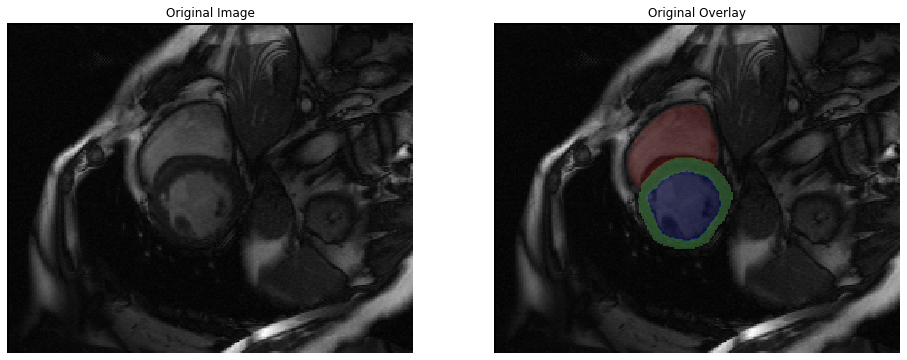

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 16))
ax1.axis('off')
ax2.axis('off')

ax1.imshow(img, cmap="gray")
ax1.set_title("Original Image")

masked = np.ma.masked_where(mask == 0, mask)
ax2.imshow(img, cmap="gray")
ax2.imshow(masked, 'jet', interpolation='bilinear', alpha=0.25)
ax2.set_title("Original Overlay")

### Generate dataframe with info

In [50]:
info = []

In [51]:
train_df = pd.read_csv("../utils/data/train.csv")
train_df.head()

,External code,Vendor,Centre,Labeled,Type,Phase,Slice
0,A0S9V9,A,1,True,ED,0,0
1,A0S9V9,A,1,True,ED,0,1
2,A0S9V9,A,1,True,ED,0,2
3,A0S9V9,A,1,True,ED,0,3
4,A0S9V9,A,1,True,ED,0,4


In [52]:
for subdir, dirs, files in tqdm(list(os.walk(os.path.join(rootdir, "Labeled")))):
    for file in files:
        if not "gt" in file:
            file_path = os.path.join(subdir, file)
            volume_img, _, _ = load_nii(file_path)
            c_patient = file[:file.find("_")]
            c_vendor = train_df.loc[train_df["External code"]==c_patient].iloc[0]["Vendor"]
            c_centre = train_df.loc[train_df["External code"]==c_patient].iloc[0]["Centre"]
        
            for c_phase in range(volume_img.shape[3]):
                # We must check that the volume is not labeled, no match for current phase and patient
                if len(df.loc[(df["External code"]==c_patient) & (df["Phase"]==c_phase)]) == 0:
                    # Iterate over slices, predict and save image slice (not normalized) 
                    # and his mask as numpy array

                    for c_slice in range(volume_img.shape[2]):

                        info.append({
                            "External code": c_patient, "Vendor": c_vendor, 
                            "Centre": c_centre, "FromLabeled": True,
                            "Phase": c_phase, "Slice": c_slice
                        })

In [53]:
for subdir, dirs, files in tqdm(list(os.walk(os.path.join(rootdir, "Unlabeled")))):
    for file in files:
        if not "gt" in file:
            file_path = os.path.join(subdir, file)
            volume_img, _, _ = load_nii(file_path)
            c_patient = file[:file.find("_")]
            c_vendor = train_df.loc[train_df["External code"]==c_patient].iloc[0]["Vendor"]
            c_centre = train_df.loc[train_df["External code"]==c_patient].iloc[0]["Centre"]
        
            for c_phase in range(volume_img.shape[3]):
                # We must check that the volume is not labeled, no match for current phase and patient
                if len(df.loc[(df["External code"]==c_patient) & (df["Phase"]==c_phase)]) == 0:
                    # Iterate over slices, predict and save image slice (not normalized) 
                    # and his mask as numpy array

                    for c_slice in range(volume_img.shape[2]):

                        info.append({
                            "External code": c_patient, "Vendor": c_vendor, 
                            "Centre": c_centre, "FromLabeled": False,
                            "Phase": c_phase, "Slice": c_slice
                        })

In [54]:
info_df = pd.DataFrame(info)
info_df.head()

,External code,Vendor,Centre,FromLabeled,Phase,Slice
0,F8N2S1,B,3,True,0,0
1,F8N2S1,B,3,True,0,1
2,F8N2S1,B,3,True,0,2
3,F8N2S1,B,3,True,0,3
4,F8N2S1,B,3,True,0,4


In [55]:
info_df.to_csv("../utils/data/weakly.csv", index=False)